In [219]:
import numpy as np
from collections import defaultdict

from stat_util import sample_niw
from math import sqrt

float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})

In [220]:
# gen user data
n_users = 800
identities_of_interest = set(['terrorist','thug','black','white','girl','boy','police','gf','coach'])

identity_uid_vals = defaultdict(lambda: defaultdict(list))

user_data = open("test_data/user_out_test_run.txt")
for line in user_data:
    uid, iden, c1,c0 = line.strip().split("\t")
    if iden in identities_of_interest:
        identity_uid_vals[iden][uid].append([float(c1),float(c0)])

full_data = {}
for identity, user_data in identity_uid_vals.items():
    mat = []
    for d in user_data.values():
        mat.append([[x[0] for x in d], [x[1] for x in d]])
    for i in range(n_users-len(mat)):
        mat.append([[],[]])
    full_data[identity] = mat

In [172]:
# get priors (just for e here)
sent_dict = {}
for x in open("../data/sentiment_data/clean_epa_terms.txt"):
    x_spl = x.split("\t")
    sent_dict[x_spl[0]] = float(x_spl[1])
    
identity_values = {k : sent_dict.get(k) for k in identities_of_interest}

In [181]:
identity_values['gf'] = -1
index_to_identity = identity_values.keys()

In [182]:
data = full_data['gf']

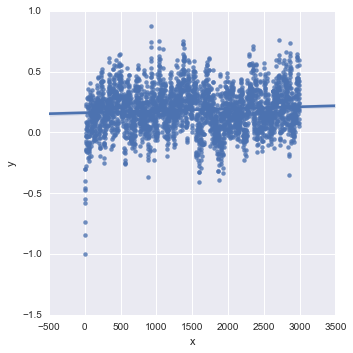

In [218]:
# priors
#mu_0 = np.array([identity_values[k] for k in index_to_identity])
mu_0 = np.array([identity_values['gf']])
sigma_0 = np.identity(len(mu_0))
sigma = sigma_0.copy()
mu = mu_0.copy()
precision_matrix = np.linalg.inv(sigma)

n_docs = n_users
phi = np.random.multivariate_normal(mu,sigma, n_users)

def iterate(mu,phi,precision_matrix,data,kappa,n_docs,nu,sigma_0,sigma):
    for i,u_phi in enumerate(phi):
        for k,elt in enumerate(u_phi):
            prior_var = 1/precision_matrix[k,k]
            #prior_mean = np.dot(precision_matrix[:, k], (u_phi - mu))
            #prior_mean -= precision_matrix[k,k] * (u_phi[k] - mu[k])
            #prior_mean = mu[k] - prior_var*prior_mean
            prior_mean = mu

            c1_all, c0_all = np.array(data[i][0]),np.array(data[i][1])
            x_i = -(c1_all/(2*c0_all))
            s_i = beta/(2*np.abs(c0_all))
            var = 1./(1./prior_var + (1./s_i).sum())
            b = prior_mean/prior_var + (x_i/s_i).sum()
            exp_mean = b*var
            u_phi[k] = np.random.normal(exp_mean, sqrt(var))
            
    #print ' into sample gaussian???'
    phi_bar = phi.mean(axis=0)
    normed_phi = phi - phi_bar

    q = np.einsum('ij,ik->jk', normed_phi, normed_phi)
    const_1 = n_docs/(kappa + n_docs)
    exp_mu = mu_0 * (kappa/(kappa + n_docs)) + (phi_bar * const_1)

    factor = nu*const_1
    exp_cov = sigma + q
    exp_cov += np.outer((phi_bar - mu_0),(phi_bar - mu_0)) * factor
    mu, sigma =  sample_niw(exp_mu, exp_cov,kappa+n_docs, nu+n_docs)
    precision_matrix = np.linalg.inv(sigma)
    return mu,sigma,precision_matrix,phi


beta = 1.
kappa = 30.
nu = 10.
mus = []
sigmas = []
for i in range(3000):
    if i % 1 == 0:
        sigmas.append(sigma[0][0])
        mus.append(mu[0])
#         print i, mu[0]
#         print " ".join([str(x) for x in phi])
#         print 
    mu,sigma,precision_matrix,phi = iterate(mu,phi,precision_matrix,data,kappa,n_docs,nu,sigma_0,sigma)
    
import pandas as pd
import seaborn as sns 
sns.set()
%matplotlib inline

#ms = [x for i, x in enumerate(mus) if i % 10 == 0]
sns.lmplot('x','y',pd.DataFrame(zip(range(len(mus)),mus),columns=['x','y']))

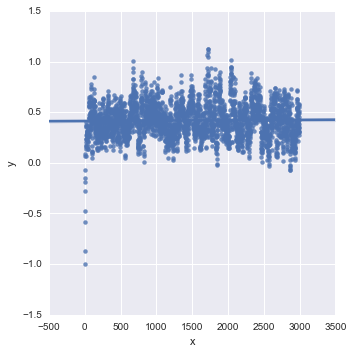